# What is Pneumonia?

**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**

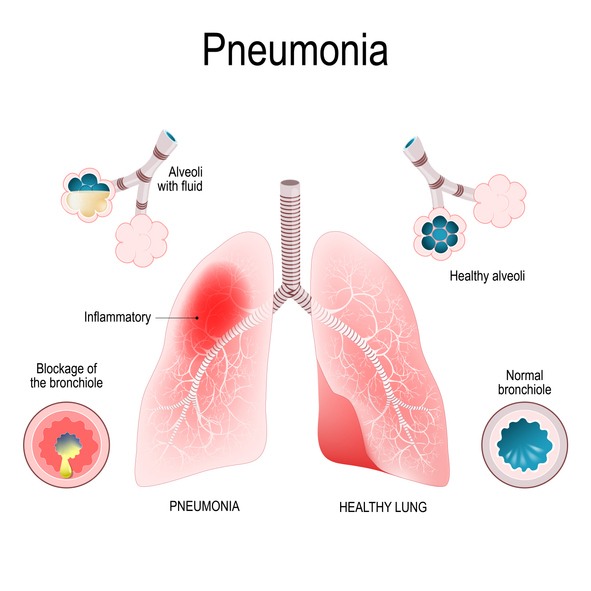

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

Using TensorFlow backend.


# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading Data Sets

In [3]:
train = get_training_data('chest_xray/train')
test = get_training_data('chest_xray/test')
val = get_training_data('chest_xray/val')

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



# Data Visulization

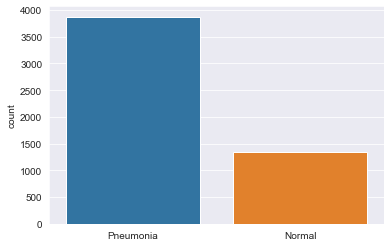

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

In [5]:
print(l.count('Pneumonia'),l.count('Normal'))
print('Pneumonia % : ',(l.count('Pneumonia')/len(l)*100))
print('Normal % : ',(l.count('Normal')/len(l)*100))

3875 1341
Pneumonia % :  74.29064417177914
Normal % :  25.709355828220858


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

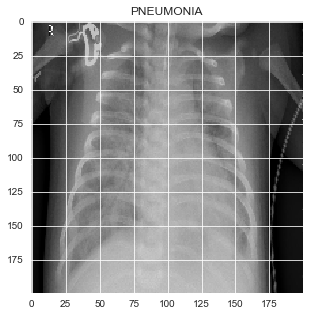

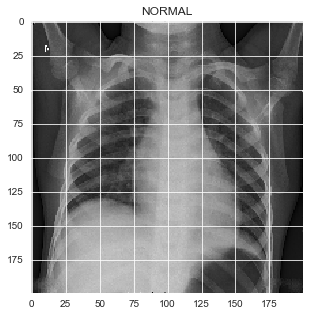

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
x_train.ndim

3

In [10]:
img_size=200
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images


datagen.fit(x_train)



For the data augmentation, i choosed to :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset.

# Training the model

In [28]:
loss=[]
acc=[]

# Model I

In [12]:
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 128)      

In [13]:
history_model1 = model1.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val,y_val))

Epoch 1/10
163/163 [==============================] - 237s 1s/step - loss: 0.4260 - accuracy: 0.8031 - val_loss: 1.3126 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 256s 2s/step - loss: 0.2999 - accuracy: 0.8683 - val_loss: 1.2080 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 274s 2s/step - loss: 0.2722 - accuracy: 0.8873 - val_loss: 1.9422 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 274s 2s/step - loss: 0.2368 - accuracy: 0.8986 - val_loss: 0.5854 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 273s 2s/step - loss: 0.2196 - accuracy: 0.9086 - val_loss: 0.9932 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 244s 1s/step - loss: 0.1960 - accuracy: 0.9212 - val_loss: 1.3243 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 260s 2s/step - loss: 0.1940 - accuracy: 0.9241 - val_loss: 0.9433 - val_accuracy: 0.5625

In [29]:
x=model1.evaluate(x_test,y_test)[0]*100 
y=model1.evaluate(x_test,y_test)[1]*100
loss.append(x)
acc.append(y)

624/624 [==============================] - 6s 9ms/step


In [15]:
model2 = Sequential()
model2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Flatten())
model2.add(Dense(units = 128 , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1 , activation = 'sigmoid'))
model2.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 128)      

In [16]:
history_model2 = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_test,y_test))

Epoch 1/10
163/163 [==============================] - 260s 2s/step - loss: 0.5286 - accuracy: 0.7437 - val_loss: 0.5959 - val_accuracy: 0.6619
Epoch 2/10
163/163 [==============================] - 246s 2s/step - loss: 0.3476 - accuracy: 0.8457 - val_loss: 0.5678 - val_accuracy: 0.7596
Epoch 3/10
163/163 [==============================] - 247s 2s/step - loss: 0.2505 - accuracy: 0.8953 - val_loss: 0.2649 - val_accuracy: 0.8221
Epoch 4/10
163/163 [==============================] - 245s 2s/step - loss: 0.2307 - accuracy: 0.9086 - val_loss: 0.5256 - val_accuracy: 0.8478
Epoch 5/10
163/163 [==============================] - 250s 2s/step - loss: 0.2162 - accuracy: 0.9141 - val_loss: 0.1841 - val_accuracy: 0.8301
Epoch 6/10
163/163 [==============================] - 243s 1s/step - loss: 0.1944 - accuracy: 0.9227 - val_loss: 0.7512 - val_accuracy: 0.8558
Epoch 7/10
163/163 [==============================] - 250s 2s/step - loss: 0.1999 - accuracy: 0.9262 - val_loss: 0.5739 - val_accuracy: 0.8045

In [30]:
x=model2.evaluate(x_test,y_test)[0]*100 
y=model3.evaluate(x_test,y_test)[1]*100
loss.append(x)
acc.append(y)

624/624 [==============================] - 6s 10ms/step


In [18]:
model3 = Sequential()
model3.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model3.add(Flatten())
model3.add(Dense(units = 128 , activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1 , activation = 'sigmoid'))
model3.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 64)       

In [19]:
history_model3 = model3.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val,y_val))

Epoch 1/10
163/163 [==============================] - 224s 1s/step - loss: 0.5731 - accuracy: 0.7402 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 219s 1s/step - loss: 0.4545 - accuracy: 0.7650 - val_loss: 0.7636 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 219s 1s/step - loss: 0.4316 - accuracy: 0.7799 - val_loss: 1.5709 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 225s 1s/step - loss: 0.3905 - accuracy: 0.7987 - val_loss: 1.3525 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 220s 1s/step - loss: 0.3605 - accuracy: 0.8303 - val_loss: 1.2255 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 220s 1s/step - loss: 0.3172 - accuracy: 0.8579 - val_loss: 1.6059 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 222s 1s/step - loss: 0.2858 - accuracy: 0.8721 - val_loss: 1.2385 - val_accuracy: 0.5625

In [31]:
x=model3.evaluate(x_test,y_test)[0]*100 
y=model3.evaluate(x_test,y_test)[1]*100
loss.append(x)
acc.append(y)

624/624 [==============================] - 5s 9ms/step


In [21]:
model4 = Sequential()
model4.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model4.add(Flatten())
model4.add(Dense(units = 512 , activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(units = 1 , activation = 'sigmoid'))
model4.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 128)      

In [23]:
history_model4 = model4.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
163/163 [==============================] - 206s 1s/step - loss: 0.3089 - accuracy: 0.8694 - val_loss: 1.3797 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 180s 1s/step - loss: 0.2519 - accuracy: 0.8905 - val_loss: 1.1861 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 182s 1s/step - loss: 0.2235 - accuracy: 0.9062 - val_loss: 1.1057 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 175s 1s/step - loss: 0.2021 - accuracy: 0.9181 - val_loss: 0.7954 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 187s 1s/step - loss: 0.1964 - accuracy: 0.9233 - val_loss: 2.4584 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 174s 1s/step - loss: 0.1873 - accuracy: 0.9247 - val_loss: 0.7331 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 177s 1s/step - loss: 0.1687 - accuracy: 0.9325 - val_loss: 1.0263 - val_accuracy: 0.6250

In [32]:
x=model4.evaluate(x_test,y_test)[0]*100 
y=model4.evaluate(x_test,y_test)[1]*100
loss.append(x)
acc.append(y)

624/624 [==============================] - 5s 7ms/step


In [35]:
print("\t\t Accuracy\t\t\tLoss\n")
count=1
for a,b in zip(acc,loss):
    print("Model ",count,"\t",a,"\t",b)
    count=count+1

		 Accuracy			Loss

Model  1 	 88.62179517745972 	 33.123750636019764
Model  2 	 85.09615659713745 	 28.240160701366573
Model  3 	 85.09615659713745 	 42.24005902233796
Model  4 	 92.78846383094788 	 30.330646563416874


In [36]:
model4.save("model_4.h5")

In [38]:
from keras.models import load_model
new_model=load_model("model_4.h5")

In [39]:
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 128)      

In [44]:
predict1=new_model.predict_classes(x_test)